# Face mask detection 

In [82]:
import numpy as np 
import pandas as pd 


import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from PIL import Image
import xml.etree.ElementTree as ET
import cv2
import seaborn as sns
from keras.models import load_model



from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint


In [62]:
img_path = './data/images/maksssksksss'
anno_path = './data/annotations/maksssksksss'
class_names = {0:'with_mask', 1:'without_mask', 2:'mask_weared_incorrect'}

In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/MyDrive/CV/Project'

## Finding bounding boxes and saving it into dataframes

In [71]:
def load_pascal_annotation(filename, index):
    """
    Load image and bounding boxes info from XML file in the PASCAL VOC
    format.
    """
    file = os.path.join(anno_path + index + '.xml')
    filename = 'maksssksksss'+index
    tree = ET.parse(file)
    root = tree.getroot()
    send_obj = {}
    arr_send = []
    send_obj['width']  = int(root.find('size').find('width').text)
    send_obj['height']  = int(root.find('size').find('height').text)
    send_obj['depth']  = int(root.find('size').find('depth').text)
    # Load object bounding boxes into a data frame
    for obj in root.iter('object'):
      send_obj['xmin'] = int(obj.find('bndbox').find('xmin').text)
      send_obj['ymin'] = int(obj.find('bndbox').find('ymin').text)
      send_obj['xmax'] = int(obj.find('bndbox').find('xmax').text)
      send_obj['ymax'] = int(obj.find('bndbox').find('ymax').text)
      send_obj['filename'] = filename
      send_obj['label'] = obj.find('name').text
      send_obj = {}
      arr_send.append(send_obj)
        
    return arr_send



In [64]:

dataset = []
for ele in range(853):
  anno = load_pascal_annotation(anno_path, str(ele))
  dataset.append(anno)

# print(dataset)
full_dataset = sum(dataset, [])
# print(full_dataset)
df = pd.DataFrame(full_dataset)
df.shape

(4072, 6)

## Number of with_mask, without_mask and mask_weared_incorrect

In [65]:
df["label"].value_counts()


with_mask                2534
without_mask              598
mask_weared_incorrect      87
Name: label, dtype: int64

## Plot showing the number of with_mask, without_mask, mask_weared_incorrect

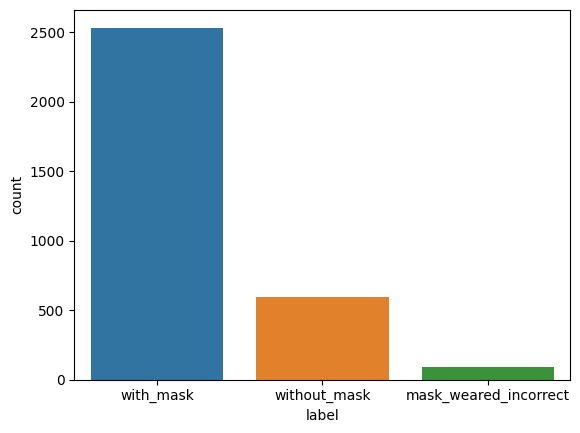

In [66]:
sns.countplot(x=df["label"])
plt.show()


## Preprocessing Data

In [47]:
def load_data(path, img_size, num_files): 

  data = []
  labels = []
  for i in range(num_files[0],num_files[1]):
    img = Image.open(path + str(i) + '.png')
    img_arr = np.array(img)
    img_input = df.loc[df['filename'] == 'maksssksksss' + str(i)]
    for ind in img_input.index:
      img_cropped = img_arr[int(img_input['ymin'][ind]):int(img_input['ymax'][ind]), int(img_input['xmin'][ind]):int(img_input['xmax'][ind]), :3]
      resized_img = cv2.resize(img_cropped, img_size, cv2.INTER_LINEAR)
      gray=cv2.cvtColor(resized_img,cv2.COLOR_BGR2GRAY) 
      data.append(gray)
      if(img_input['label'][ind] == 'with_mask'):
        labels.append(0)
      elif(img_input['label'][ind] == 'without_mask'):
        labels.append(1)
      else:
        labels.append(2)
        
  print(class_names[labels[67]])
  plt.figure
  plt.imshow(data[67], 'gray')
  plt.show()
  data=np.array(data)/255.0
  data=np.reshape(data,(data.shape[0],img_size[0],img_size[1],1))
  labels=np.array(labels)
  return data, labels


In [45]:
img_size = (100, 100)
data_range = [0,853]


with_mask


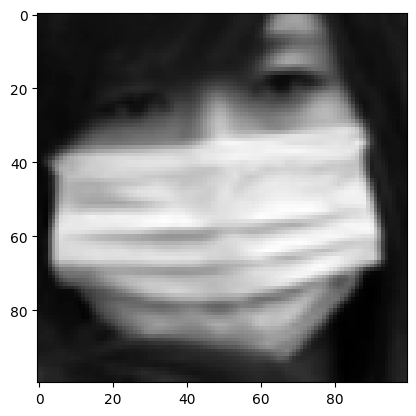

In [48]:
data, labels = load_data(img_path, img_size, data_range)
new_labels = np_utils.to_categorical(labels)
np.save('data',data)
np.save('labels',new_labels)

In [89]:
data=np.load('data.npy')
label=np.load('labels.npy')

## Sequential Convolutional Neural Network

In [86]:
model=Sequential(name="facemask_detection_model")

model.add(layers.Conv2D(filters=300, kernel_size=7, activation="LeakyReLU", input_shape=data.shape[1:]))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=200, kernel_size=5, activation="LeakyReLU"))
model.add(layers.MaxPool2D(pool_size=(2,2), strides= 2))

model.add(layers.Conv2D(filters=100, kernel_size=3, activation="LeakyReLU"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(50,activation='LeakyReLU'))
model.add(layers.Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [87]:
model.summary()

Model: "facemask_detection_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 94, 94, 300)       15000     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 47, 47, 300)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 43, 43, 200)       1500200   
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 21, 21, 200)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 19, 19, 100)       180100    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 9, 9,

In [90]:
train_data, test_data, train_labels, test_labels = train_test_split(data,label,test_size=0.2)

In [92]:
checkpoint = ModelCheckpoint('.\models\CNN_Model-{epoch:03d}.model', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history=model.fit(train_data, train_labels, epochs=20, callbacks=[checkpoint], validation_split=0.2)

Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 0.4898 - accuracy: 0.7733

INFO:tensorflow:Assets written to: .\models\CNN_Model-001.model\assets


INFO:tensorflow:Assets written to: .\models\CNN_Model-001.model\assets


65/65 [==============================] - 266s 4s/step - loss: 0.4898 - accuracy: 0.7733 - val_loss: 0.4071 - val_accuracy: 0.7961
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8316

INFO:tensorflow:Assets written to: .\models\CNN_Model-002.model\assets


INFO:tensorflow:Assets written to: .\models\CNN_Model-002.model\assets


65/65 [==============================] - 291s 4s/step - loss: 0.4010 - accuracy: 0.8316 - val_loss: 0.3332 - val_accuracy: 0.8796
Epoch 3/20
65/65 [==============================] - 280s 4s/step - loss: 0.4139 - accuracy: 0.8447 - val_loss: 2.4353 - val_accuracy: 0.4641
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.8558

INFO:tensorflow:Assets written to: .\models\CNN_Model-004.model\assets


INFO:tensorflow:Assets written to: .\models\CNN_Model-004.model\assets


65/65 [==============================] - 267s 4s/step - loss: 0.4011 - accuracy: 0.8558 - val_loss: 0.3240 - val_accuracy: 0.8757
Epoch 5/20
65/65 [==============================] - 259s 4s/step - loss: 0.3227 - accuracy: 0.8777 - val_loss: 0.3364 - val_accuracy: 0.8913
Epoch 6/20
65/65 [==============================] - 246s 4s/step - loss: 0.3444 - accuracy: 0.8762 - val_loss: 0.3781 - val_accuracy: 0.8777
Epoch 7/20
65/65 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.8879

INFO:tensorflow:Assets written to: .\models\CNN_Model-007.model\assets


INFO:tensorflow:Assets written to: .\models\CNN_Model-007.model\assets


65/65 [==============================] - 251s 4s/step - loss: 0.2996 - accuracy: 0.8879 - val_loss: 0.3028 - val_accuracy: 0.8932
Epoch 8/20
65/65 [==============================] - 299s 5s/step - loss: 0.2790 - accuracy: 0.9000 - val_loss: 0.3409 - val_accuracy: 0.8835
Epoch 9/20
65/65 [==============================] - 355s 5s/step - loss: 0.3104 - accuracy: 0.8830 - val_loss: 0.3933 - val_accuracy: 0.8583
Epoch 10/20
65/65 [==============================] - 366s 6s/step - loss: 0.2932 - accuracy: 0.8874 - val_loss: 0.3284 - val_accuracy: 0.8874
Epoch 11/20
65/65 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.8976

INFO:tensorflow:Assets written to: .\models\CNN_Model-011.model\assets


INFO:tensorflow:Assets written to: .\models\CNN_Model-011.model\assets


65/65 [==============================] - 308s 5s/step - loss: 0.2636 - accuracy: 0.8976 - val_loss: 0.2822 - val_accuracy: 0.9049
Epoch 12/20
65/65 [==============================] - 270s 4s/step - loss: 0.3376 - accuracy: 0.8825 - val_loss: 0.3538 - val_accuracy: 0.8796
Epoch 13/20
65/65 [==============================] - 256s 4s/step - loss: 0.2807 - accuracy: 0.9010 - val_loss: 0.3418 - val_accuracy: 0.8854
Epoch 14/20
65/65 [==============================] - 278s 4s/step - loss: 0.2600 - accuracy: 0.9015 - val_loss: 0.3252 - val_accuracy: 0.8951
Epoch 15/20
65/65 [==============================] - 248s 4s/step - loss: 0.2609 - accuracy: 0.9010 - val_loss: 0.3159 - val_accuracy: 0.8971
Epoch 16/20
65/65 [==============================] - 287s 4s/step - loss: 0.2480 - accuracy: 0.9049 - val_loss: 0.3277 - val_accuracy: 0.8971
Epoch 17/20
65/65 [==============================] - 284s 4s/step - loss: 0.2394 - accuracy: 0.9121 - val_loss: 0.3330 - val_accuracy: 0.9068
Epoch 18/20
65/65 

INFO:tensorflow:Assets written to: .\models\CNN_Model-019.model\assets


INFO:tensorflow:Assets written to: .\models\CNN_Model-019.model\assets


65/65 [==============================] - 282s 4s/step - loss: 0.2370 - accuracy: 0.9175 - val_loss: 0.2622 - val_accuracy: 0.9146
Epoch 20/20
65/65 [==============================] - 289s 4s/step - loss: 0.2322 - accuracy: 0.9155 - val_loss: 0.3279 - val_accuracy: 0.9010


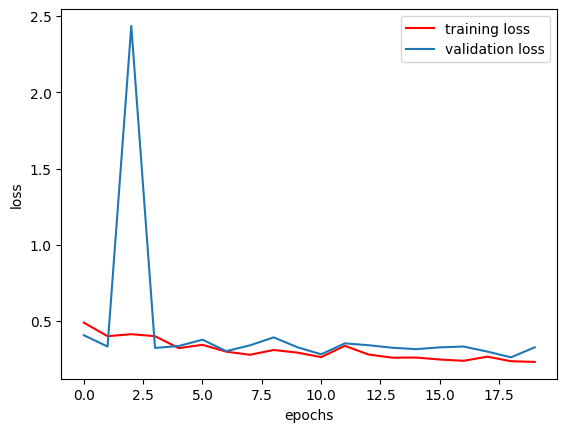

In [93]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

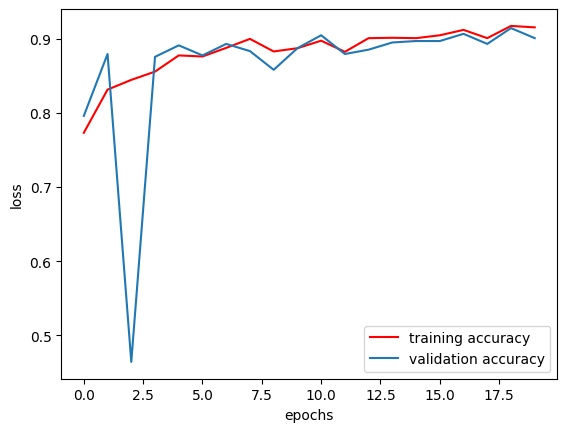

In [94]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [95]:
score = model.evaluate(test_data, test_labels, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 89.29%


In [ ]:
metrics = Metrics()
metrics.get_data()

In [96]:
def predict_img(model_name, img):
    model = load_model(model_name)
    img_predict = Image.open(img)
    face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
    img_arr = np.array(img_predict)
    gray=cv2.cvtColor(img_arr,cv2.COLOR_BGR2GRAY) 
    face = face_cascade.detectMultiScale(gray,1.3,5)
    x,y,w,h = face[0]
    face_img=gray[y:y+w,x:x+w]  
    resized=cv2.resize(face_img,(100,100))
    normalized=resized/255.0
    reshaped=np.reshape(normalized,(1,100,100,1))
    result=model.predict(reshaped)
    label=np.argmax(result,axis=1)[0]

    print('Predicted label is {} with {:0.2f}%'.format(class_names[label],result[0][label]*100))
    plt.figure
    plt.imshow(img_predict)
    plt.show()

1/1 [==============================] - 0s 104ms/step
Predicted label is with_mask with 79.37%


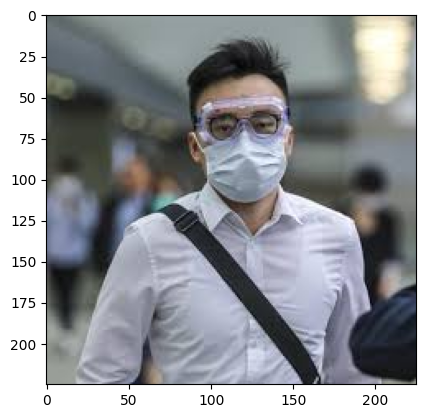

In [98]:
predict_img('./models/CNN_Model-001.model', './image2.png')

### Description of model

Layer 1: Conv2D\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; kernal size: 7*7\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; activation: LeakyReLU\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; filters: 300\
Layer 2: MaxPool2D\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; kernal size: 2*2\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; stride: 1\
Layer 3: Conv2D\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; kernal size: 5*5\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; activation: LeakyReLU\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; filters: 200\
Layer 4: MaxPool2D\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; kernal size: 2*2\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; stride: 2\
Layer 5: Conv2D\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; kernal size: 3*3\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; activation: LeakyReLU\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; filters: 200\
Layer 6: MaxPool2D\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; kernal size: 2*2\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; stride: 1\
Layer 7: Flatten\
Layer 8: Dropout = 0.6\
Layer 9: Dense\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; filters: 50\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; activation: LeakyReLU\
Layer 9: Dense\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; filters: 50\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; activation: softmax\



         


          

### Experimentation

How did you set up your experiments?
Datasets used: Train, validation, test split information
Experimentation with different models or methods
Library and tools used

### Literature Review (4 points)
• Motivation for using your method (Cite any existing work that you have used)

### Results (6 points)
• Measure of your model performance in terms of Accuracy/Precision/Recall
• Visual results e.g., Detection bounding boxes
• Graphs